# Imports

In [ ]:
import os
import numpy as np
from math import ceil

import librosa

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#from scipy.io import wavfile

# Load audio

Características:
* Monocanal
* Frecuencia de muestreo: 22050Hz
* Profundidad: 16bits


In [3]:
SAMPLE_RATE = 22050

# Data prep 

Elijo el tamaño de mis muestras de audio y preparo la matriz a utilizar

In [126]:
SIZE_STFT = 45100 #esto seguramente se pueda calcular pero bue

def doSTFT(data):
    D = librosa.stft(data)
    D = np.abs(D)
    return D.reshape(1, D.shape[0] * D.shape[1] )
    

In [ ]:
#doSTFT(matrixAudioDataNoFFT[0]).shape
#matrixAudioDataNoFFT.shape[0]

### Para varios archivos

In [159]:
SEGUNDOS_FILA = 1
SELECCION_DIR = "data/sound/pack/drumkits/"

matrixAudioDataNoFFT = np.empty((0,ceil(SAMPLE_RATE * SEGUNDOS_FILA)), np.int16)
matrixAudioData = np.empty((0, SIZE_STFT), np.float32)

def findMusic(directory):
    musicFiles = []
    
    for file in os.listdir(directory):
        if os.path.isdir(directory + file):
            musicFiles += findMusic(directory + file + "/")
        elif file.endswith(".wav"):
            musicFiles.append( directory + file )
        else:
            if not file.endswith(".asd"):
                print("Skipped:", directory + file)
    
    return musicFiles

audioFiles = findMusic( SELECCION_DIR )

print("")
print("Encontré",len(audioFiles),"archivos de audio")
print("Ahora procesando...")
print("")

for file in audioFiles:
    try:
        print(file, end="")
        #tmpSampleRate, tmpAudioData = wavfile.read(SELECCION_DIR + file)
        tmpAudioData, tmpSampleRate = librosa.core.load(file, sr = SAMPLE_RATE)

        tmpAudioData.resize(ceil(SAMPLE_RATE * SEGUNDOS_FILA))
        tmpAudioData = tmpAudioData.reshape(1, ceil(SAMPLE_RATE * SEGUNDOS_FILA))
        matrixAudioDataNoFFT = np.concatenate((matrixAudioDataNoFFT, tmpAudioData), axis = 0 )
        #matrixAudioDataNoFFT = np.stack((matrixAudioDataNoFFT, tmpAudioData), axis=0)

        stft = doSTFT(matrixAudioDataNoFFT[ matrixAudioDataNoFFT.shape[0] - 1 ])
        #print("stft: ", stft.shape)
        #print("Matriz FFT final: ", matrixAudioData.shape)

        matrixAudioData = np.concatenate((matrixAudioData, stft ), axis = 0 )
        print(" [OK]")
    except:
        print(" [FAIL]")
        
print("")
print("Matriz final: ", matrixAudioDataNoFFT.shape)
print("Matriz FFT final: ", matrixAudioData.shape)

Skipped: data/sound/pack/drumkits/.DS_Store

Encontré 2183 archivos de audio
Ahora procesando...

data/sound/pack/drumkits/Roland MT-32/Bongo L.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Hat Closed.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Hat Open-02.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Bassdrum.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Snaredrum-01.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Snaredrum-02.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Conga Muted H.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Tambourine.wav [OK]
data/sound/pack/drumkits/Roland MT-32/RimShot.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Conga L.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Whistle Short.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Whistle.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Ride.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Claves.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Crash.wav [OK]
data/sound/pack/drumkits/Roland MT-32/Agogo L.wav 

# Principal Component Analysis

In [160]:
from sklearn.decomposition import PCA
pca = PCA(n_components=800) #500
pca.fit(matrixAudioData)
print("Variance explained:", pca.explained_variance_ratio_.sum())
matrixAudioDataTransformed = pca.transform(matrixAudioData)
# print(matrixAudioDataTransformed[0])
print("shape transformed:", matrixAudioDataTransformed.shape)

Variance explained: 0.989721
shape transformed: (2182, 800)


# Cluster Jerárquico

In [24]:
#matrixAudioDataTransformed = matrixAudioData

In [184]:
from scipy.cluster import hierarchy as h
from scipy.spatial import distance as dist

distanceFunction = 'cosine' #canberra, cityblock, braycurtis, euclidean
linkageType = 'average' #single, complete, weighted, average

distanceMatrix = dist.pdist(matrixAudioDataTransformed, distanceFunction) 
clusters = h.linkage(distanceMatrix, linkageType)


c,d=h.cophenet(clusters, distanceMatrix) #factor cofonético
print("distancia:",distanceFunction)
print("linkage:",linkageType)
print("cofonetica:",c)

distancia: cosine
linkage: average
cofonetica: 0.779441199203


### Dendograma

In [189]:
THRESHOLD = 0.96


cutTree = h.cut_tree(clusters, height= THRESHOLD)
# minutos = 0
# segundos = 0
# for label in cutTree:
#     print(str(minutos) + ":" + str(segundos), str(label))
#     segundos += SEGUNDOS_FILA
#     if ( segundos >= 60 ):
#         minutos += 1
#         segundos -= 60

# print(clusters.shape)
# print(clusters)
# exit()

#matrixAudioDataAndCluster = np.hstack((matrixAudioDataTransformed, cutTree))

cantClusters = np.unique(cutTree).size
print("Cantidad de clusters:", cantClusters)

Cantidad de clusters: 5


<IPython.core.display.Javascript object>


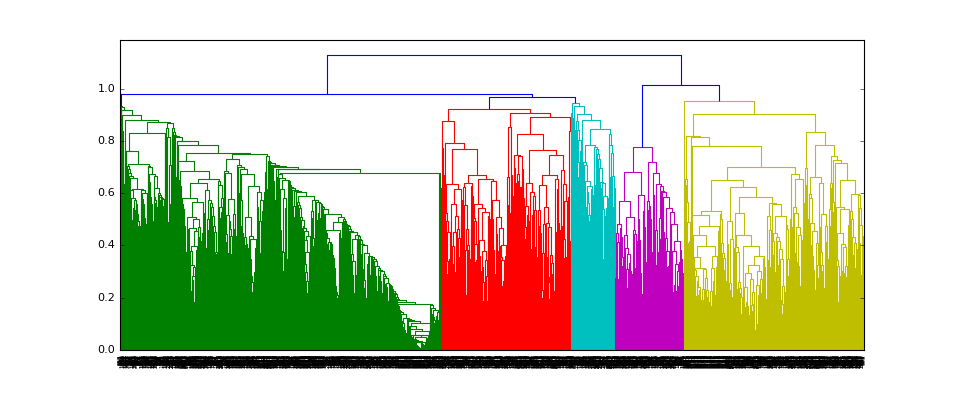

In [190]:
%matplotlib notebook

plt.figure(figsize=(12, 5))
dn = h.dendrogram(clusters, color_threshold = THRESHOLD)
plt.show()

### Histograma

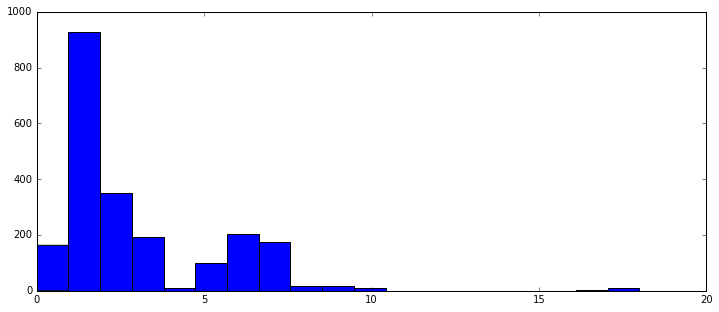

Count:
[ 163.  929.  352.  192.    9.   98.  202.  175.   17.   17.   11.    1.
    1.    1.    1.    1.    1.    2.    9.]


In [174]:
%matplotlib inline

plt.figure(figsize=(12, 5))
n = plt.hist(cutTree, bins=cantClusters)[0]
plt.show()
print("Count:")
print(n)

In [178]:
cutTree

array([[0],
       [1],
       [1],
       ..., 
       [1],
       [7],
       [7]])

# Multi-dimensional scaling

In [168]:
#check http://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html

from sklearn.manifold import MDS 
from sklearn.metrics import pairwise_distances

#similarities = pairwise_distances(matrixAudioDataTransformed, metric = distanceFunction, n_jobs = -1)
similarities = pairwise_distances( dist.squareform(distanceMatrix), n_jobs = -1)

mds = MDS(n_components=2, dissimilarity="precomputed", n_jobs=-1) #max_iter=3000, eps=1e-9, 
positions = mds.fit(similarities).embedding_
#positions = mds.fit(distanceMatrix).embedding_
print("Positions shape:", positions.shape)

Positions shape: (2182, 2)


### Scatterplot

<IPython.core.display.Javascript object>


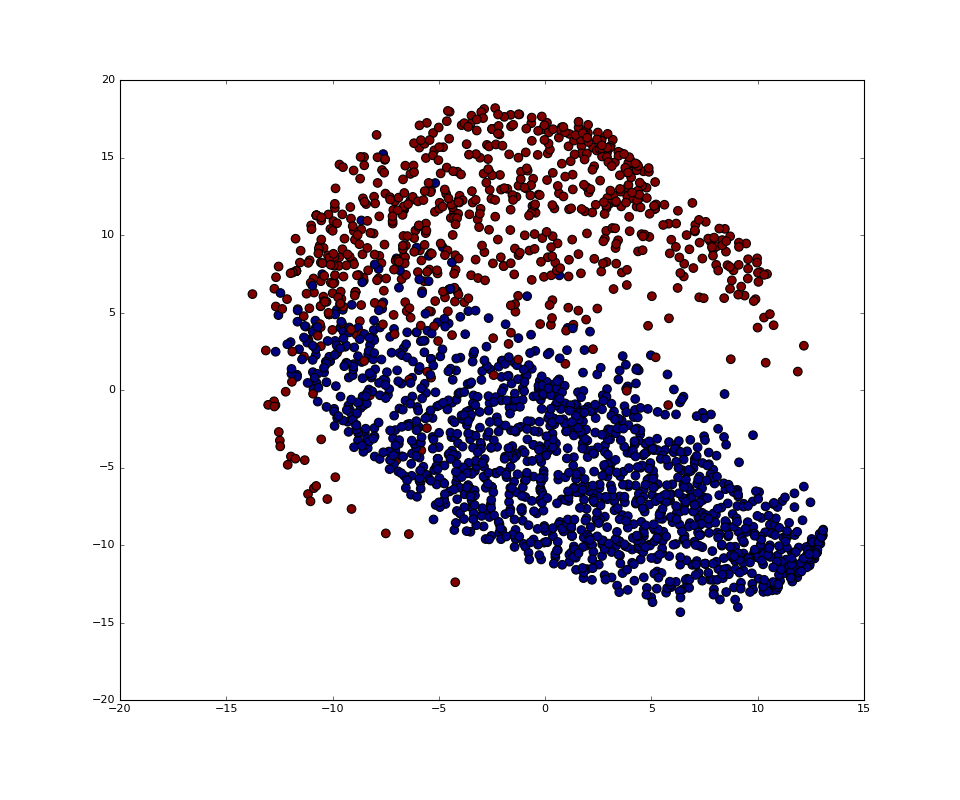

In [187]:
# para debuggear
#
# import sys
# nb_stdout = sys.stdout
# sys.stdout = open('/dev/stdout', 'w')

%matplotlib notebook

import sounddevice as sd
#sd.default.samplerate = SAMPLE_RATE
#sd.default.device = 18

def pointClicked(event):
    fileToPlayData = None
    fileToPlaySampleRate = None
    
    if ( event.xdata == None ):
        return
    
    for i in range(0, positions.shape[0]):
        if dist.euclidean( positions[i,:], np.array( (event.xdata,event.ydata) ) ) < THRESHOLD/8:
            fileToPlay = audioFiles[i]
            fileToPlaySampleRate, fileToPlayData = wavfile.read(fileToPlay)
            #sound = matrixAudioData[i]
            #ound = matrixAudioDataNoFFT[i]
            
    if fileToPlayData != None:
        sd.play(fileToPlayData, fileToPlaySampleRate, blocking = True)

fig = plt.figure(figsize=(12, 10))
plt.scatter(positions[:,0], positions[:,1], s=60, c=cutTree)
fig.canvas.mpl_connect('button_press_event', pointClicked )             
plt.show()

In [12]:
sd.stop()
